In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import scipy as sp
import textwrap

In [3]:
#status standing data
current_status = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-current-status.csv')
# Which AUs belong to which ministry standing data
au_ministry_data = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-au-ministry.csv')
#current_status.iloc[64,0]
# Analysis date
analysis_date = datetime(2023, 3, 1)
# Import Raw Data
df = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/raw-data/srm-raw-data/230301-srm-raw-data.csv', low_memory=False)
# Define function to remove extra characters from current state string in the raw data
def remove_extra_chars(string):
    return string.split(' $')[0]

# Apply function to 'Current State' column
df['Current State'] = df['Current State'].apply(remove_extra_chars)
# Columns to keep immediately, filtering out the many columns that are unneeded in the raw data
df_columns_to_keep = [
        'Srid','Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Entity','Account Code','Exchange Rate','Total Cost Of Line','Amended Total Cost Of Line',
        'Savings Of Line','Total Sr Savings','Spending Team Action','Spending Team Action Date',
        'Price Evaluation Action','Price Evaluation Action Date','Engineering Directorate Action',
        'Engineering Directorate Action Date','Publications Directorate Action','Publications Directorate Action Date',
        'Director Of Spending Action','Director Of Spending Action Date','Dg Pa Action','Dg Pa Action Date',
        'Minister Of Finance Action','Minister Of Finance Action Date','Com Action','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date','Second Round Com Action Date',
        'Second Round Final Approval Date','Final Approval Date','Current State']
df_filtered = df.loc[:, df_columns_to_keep]
#df_filtered.head(5)

In [4]:
# Create a Most Recent Action column
#columns to include are all the columns from which the 'most recent action' could be. I.e. the most recent action
# is the date that is most recent of the actions listed below.
columns_to_include = [
        'Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Spending Team Action Date',
        'Price Evaluation Action Date',
        'Engineering Directorate Action Date','Publications Directorate Action Date',
        'Director Of Spending Action Date','Dg Pa Action Date',
        'Minister Of Finance Action Date','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date',
        'Second Round Com Action Date','Second Round Final Approval Date','Final Approval Date']

df_filtered['Most Recent Action'] = df_filtered[columns_to_include].max(axis=1)

# convert date_column to datetime format
df_filtered['Most Recent Action'] = pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d %I:%M %p', errors='coerce').fillna(pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d', errors='coerce'))
# Display updated dataframe
#df['Current State'].unique()

# Merge standing data and raw data to get the status columns
current_status['Current State'] = current_status['Current State'].str.upper()
df_filtered['Current State'] = df_filtered['Current State'].str.upper()
df_filtered = pd.merge(df_filtered, current_status,how='left', on='Current State')

In [5]:
# ADD STATUS COLUMN
def final_status(row):
    if row['Current State'] == "REVOKED" and row['Date Submitted To Mofe'] == "-":
        
        return "Not Submitted"
    
    elif row['Current State'] == "REVOKED" and row['Final Approval Date'] != "-":
        if row['Minister Of Finance Action'] == "Approved By Minister Of Finance" or row['Minister Of Finance Action'] == "Amended and Approved By Minister Of Finance" or  row['Minister Of Finance Action'] == "Pending Tender":
                
            return "Revoked After Approval"
        
        elif row['Com Action'] == "Approved By Council Of Ministers" or row['Com Action'] == "Amended And Approved By Council Of Ministers" or row['Com Action'] == "Pending Tender By Council Of Ministers":
                
            return "Revoked After Approval"
        
        elif row['Minister Of Finance Action'] == "Rejected By Minister Of Finance" or row['Com Action'] == "Rejected By Council Of Ministers":
                
            return "Revoked After Rejection"
        
    elif row['Status'] == 'In process':
        return 'In Process'
    
    elif row['Status'] == 'Not submitted':
        return 'Not Submitted'
    
    elif row['Status'] == 'Revoked':
        return 'Revoked'
    
    elif row['Status'] == 'Rejected':
        return 'Rejected'
    
    elif row['Status'] == 'Approved':
        if row['Total Sr Savings'] == 0:
            return 'Approved'
        else:
            return 'Amended'
    else:
        return np.nan
    
df_filtered['Final Status'] = df_filtered.apply(final_status, axis=1)
# Replace '-' values with zeros in the 'Savings Of Line' column and blanks in the exchange rate column
# same for amended total cost of line, and total cost of line. and exchange rate remove na's

In [6]:
df_filtered['Savings Of Line'] = df_filtered['Savings Of Line'].replace('-', 0).fillna(0)
df_filtered['Amended Total Cost Of Line'] = df_filtered['Amended Total Cost Of Line'].replace('-', 0).fillna(0)
df_filtered['Total Cost Of Line'] = df_filtered['Total Cost Of Line'].replace('-', 0).fillna(0)
df_filtered['Exchange Rate'] = df_filtered['Exchange Rate'].fillna(0)

# Convert the 'Savings Of Line' column to float type
df_filtered['Savings Of Line'] = df_filtered['Savings Of Line'].astype(float)
# Convert the 'Amended Total Cost Of Line' column to float type
df_filtered['Amended Total Cost Of Line'] = df_filtered['Amended Total Cost Of Line'].astype(float)
# Convert the 'Savings Of Line' column to float type
df_filtered['Total Cost Of Line'] = df_filtered['Total Cost Of Line'].astype(float)
### ADD 'LINE ITEM SAVINGS IQD'
df_filtered['Line Item Savings IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Savings Of Line'], axis=1)
### ADD 'Amended Line Item IQD'
df_filtered['Amended Line Item IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Amended Total Cost Of Line'], axis=1)
### Add 'Original Line Item IQD'
df_filtered['Original Line Item IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Total Cost Of Line'], axis=1)
### ADD 'Original Total Cost of SR'

# Group the rows of the DataFrame by the values in 'Srid',
# and calculate the sum of 'Original Line Item IQD' for each group
sum_original = df_filtered.groupby('Srid')['Original Line Item IQD'].sum()

# Create a new column 'Original Total Cost of SR' with the calculated values
df_filtered['Original Total Cost of SR'] = df_filtered['Srid'].map(sum_original)

In [7]:
# Add ministry column
df_filtered = pd.merge(df_filtered, au_ministry_data,how='left', on='Entity')
#df_filtered_ministry.head(5)

In [8]:
# Add time since last action column
def days_between_dates(row):
#    date1 = datetime.strptime(row['Most Recent Action'], '%Y-%m-%d')
#    date2 = datetime.strptime(analysis_date, '%Y-%m-%d')
    days = (analysis_date - row['Most Recent Action']).days
    return days

df_filtered['days_since_last_action'] = df_filtered.apply(days_between_dates, axis=1)
df_filtered.head()

,Srid,Date Submitted To Mofe,Approval Number Issued At,Ministry Input Id Issued At,Ministry Id Issued At,Ministry Diwan Reviewer Action Date,Ministry Diwan Decision Maker Action Date,Entity,Account Code,Exchange Rate,...,Status,Status (Updated),Final Status,Line Item Savings IQD,Amended Line Item IQD,Original Line Item IQD,Original Total Cost of SR,Ministry,Analyst,days_since_last_action
0,SRID-1,2020-07-20 10:29 pm,2020-10-15,2020-07-20,2020-07-20,-,2020-07-20 10:29 pm,وەزارەتی گواستنەوە و گەیاندن,2-01-02-09-02-00,1.0,...,Rejected,Rejected - Inactive,Rejected,0.0,341000000.0,341000000.0,806000000.0,MOTAC,Helen,867.0
1,SRID-1,2020-07-20 10:29 pm,2020-10-15,2020-07-20,2020-07-20,-,2020-07-20 10:29 pm,وەزارەتی گواستنەوە و گەیاندن,2-01-04-07-00-00,1.0,...,Rejected,Rejected - Inactive,Rejected,0.0,62000000.0,62000000.0,806000000.0,MOTAC,Helen,867.0
2,SRID-1,2020-07-20 10:29 pm,2020-10-15,2020-07-20,2020-07-20,-,2020-07-20 10:29 pm,وەزارەتی گواستنەوە و گەیاندن,2-01-03-08-02-00,1.0,...,Rejected,Rejected - Inactive,Rejected,0.0,155000000.0,155000000.0,806000000.0,MOTAC,Helen,867.0
3,SRID-1,2020-07-20 10:29 pm,2020-10-15,2020-07-20,2020-07-20,-,2020-07-20 10:29 pm,وەزارەتی گواستنەوە و گەیاندن,2-01-03-08-02-00,1.0,...,Rejected,Rejected - Inactive,Rejected,0.0,31000000.0,31000000.0,806000000.0,MOTAC,Helen,867.0
4,SRID-1,2020-07-20 10:29 pm,2020-10-15,2020-07-20,2020-07-20,-,2020-07-20 10:29 pm,وەزارەتی گواستنەوە و گەیاندن,2-01-03-08-02-00,1.0,...,Rejected,Rejected - Inactive,Rejected,0.0,217000000.0,217000000.0,806000000.0,MOTAC,Helen,867.0



# code for dataframe for in process time graph


In [9]:
in_process_df = df_filtered[df_filtered['Final Status'] == 'In Process']

In [10]:
in_process_df = in_process_df[in_process_df['Most Recent Action'] >= pd.Timestamp("2020-07-01")]

In [11]:
in_process_df.head()

,Srid,Date Submitted To Mofe,Approval Number Issued At,Ministry Input Id Issued At,Ministry Id Issued At,Ministry Diwan Reviewer Action Date,Ministry Diwan Decision Maker Action Date,Entity,Account Code,Exchange Rate,...,Status,Status (Updated),Final Status,Line Item Savings IQD,Amended Line Item IQD,Original Line Item IQD,Original Total Cost of SR,Ministry,Analyst,days_since_last_action
11,SRID-3,2020-07-21 02:30 pm,-,2020-07-07,2020-07-19,-,2020-07-21 02:30 pm,وەزارەتی شارەوانی و گەشت و گوزار,2-01-02-06-05-00,1.0,...,In process,NaN,In Process,0.0,497952247.0,497952247.0,497952247.0,MOMT,Namiq,916.0
21,SRID-5,2020-07-22 01:51 pm,-,2020-06-07,2020-07-21,-,2020-07-22 01:51 pm,وەزارەتی کارەبا,2-01-04-02-02-00,1.0,...,In process,NaN,In Process,0.0,13281600.0,13281600.0,456000000.0,MOEL,Nawroz,581.0
22,SRID-5,2020-07-22 01:51 pm,-,2020-06-07,2020-07-21,-,2020-07-22 01:51 pm,وەزارەتی کارەبا,2-01-04-02-02-00,1.0,...,In process,NaN,In Process,0.0,42000000.0,42000000.0,456000000.0,MOEL,Nawroz,581.0
23,SRID-5,2020-07-22 01:51 pm,-,2020-06-07,2020-07-21,-,2020-07-22 01:51 pm,وەزارەتی کارەبا,2-01-04-02-02-00,1.0,...,In process,NaN,In Process,0.0,30000000.0,30000000.0,456000000.0,MOEL,Nawroz,581.0
24,SRID-5,2020-07-22 01:51 pm,-,2020-06-07,2020-07-21,-,2020-07-22 01:51 pm,وەزارەتی کارەبا,2-01-04-02-02-00,1.0,...,In process,NaN,In Process,0.0,60000000.0,60000000.0,456000000.0,MOEL,Nawroz,581.0


In [12]:
#Initialise the dataframe we are going to use

# Define the column headings
columns = ['Less than a week', '1 week to 1 Month', '1 Month to 6 Months', 'Over 6 months']

# Define the index values
index = ['Spend Analyst',
         'Price Evaluation Committee',
         'Engineering Price Evaluation Directorate',
         'Director of Spending',
         'Director General',
         'Minister of Finance',
         'Council of Ministers',
         'Spend Analysts (End)']

# Define the data
data = [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]

# Create the dataframe
waittime_by_user_df = pd.DataFrame(data=data, index=index, columns=columns)

# Load data from in_process_df and populate waittime_by_user_df
for index_value in index:
    # Filter rows in in_process_df based on the current index value of waittime_by_user_df
    filtered_df = in_process_df[in_process_df['User Currently With'] == index_value]
    
    # Count the number of unique Srid values in each time bucket based on days_since_last_action
    less_than_week_count = filtered_df[(filtered_df['days_since_last_action'] >= 0) & (filtered_df['days_since_last_action'] < 7)]['Srid'].nunique()
    week_to_month_count = filtered_df[(filtered_df['days_since_last_action'] >= 7) & (filtered_df['days_since_last_action'] < 30)]['Srid'].nunique()
    month_to_six_months_count = filtered_df[(filtered_df['days_since_last_action'] >= 30) & (filtered_df['days_since_last_action'] < 180)]['Srid'].nunique()
    over_six_months_count = filtered_df[filtered_df['days_since_last_action'] >= 180]['Srid'].nunique()
    
    # Update the corresponding elements in waittime_by_user_df
    waittime_by_user_df.loc[index_value, 'Less than a week'] = less_than_week_count
    waittime_by_user_df.loc[index_value, '1 week to 1 Month'] = week_to_month_count
    waittime_by_user_df.loc[index_value, '1 Month to 6 Months'] = month_to_six_months_count
    waittime_by_user_df.loc[index_value, 'Over 6 months'] = over_six_months_count


In [13]:
waittime_by_user_df

,Less than a week,1 week to 1 Month,1 Month to 6 Months,Over 6 months
Spend Analyst,194,168,222,90
Price Evaluation Committee,51,12,11,18
Engineering Price Evaluation Directorate,20,69,35,1
Director of Spending,57,54,20,10
Director General,17,8,21,40
Minister of Finance,290,20,118,203
Council of Ministers,5,12,11,3
Spend Analysts (End),39,62,65,384


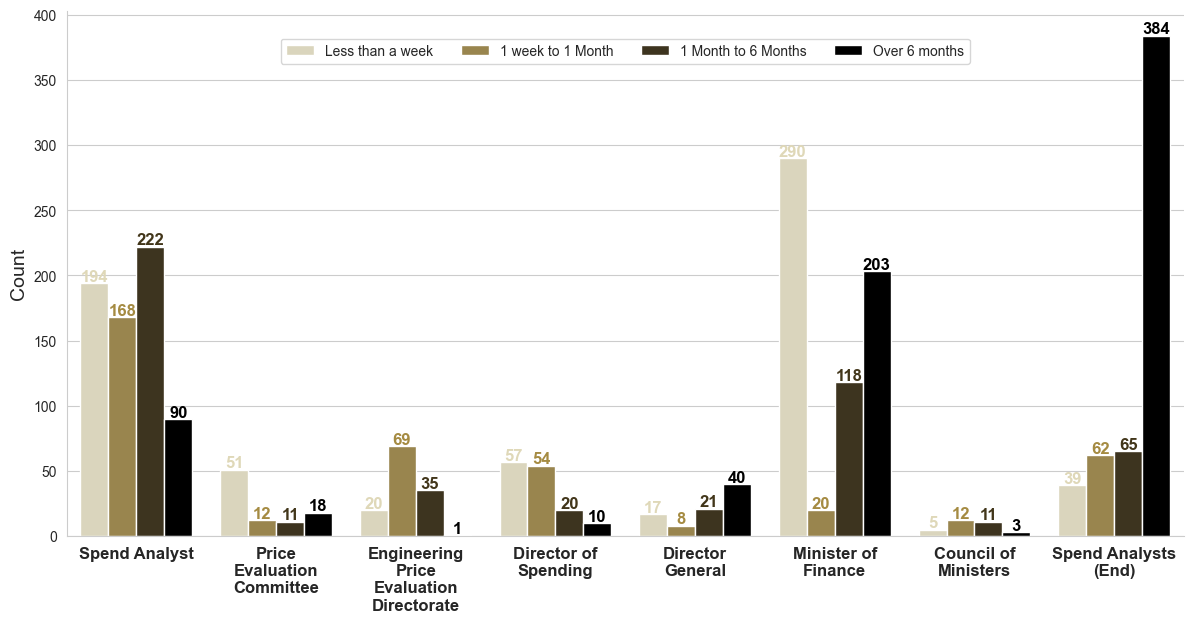

In [38]:
sns.set_style("whitegrid")

# Create a melted version of the dataframe for seaborn
melted_df = waittime_by_user_df.reset_index().melt(id_vars=["index"], var_name="Time Period", value_name="Count")

#Define the colours to be used
colours = ['#dfd8b8','#a58b42','#42361a','#000000']

# Wrap x-axis tick labels
wrapped_labels = [textwrap.fill(label, 15) for label in waittime_by_user_df.index]

# Create the catplot
catplot = sns.catplot(data=melted_df, x="index", y="Count", hue="Time Period", kind="bar", palette=colours, height=6, aspect=2, legend=False)

# Set the title and axis labels
#catplot.fig.suptitle("Spend Request Status", fontsize=16)
catplot.set_xlabels("", fontsize=14)
catplot.set_ylabels("Count", fontsize=14)

# Rotate the x tick labels
catplot.set_xticklabels(wrapped_labels,fontsize=12, fontweight=750,fontstretch=999)

ax = catplot.ax
for i,p in enumerate(ax.containers):
    for q in p.patches:
        text = f"{q.get_height():.0f}"
        x = q.get_x() + q.get_width() / 2
        y = q.get_y() + q.get_height() + 5
        ax.annotate(text, (x, y), ha='center', va='center', fontsize=12, fontweight='bold', color=colours[i])

# Adjust the legend positioning
catplot.ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.96))

# Display the plot

sns.despine()
plt.show()
